<a href="https://colab.research.google.com/github/Naimish240/TwitchEmoteGenerator/blob/main/TwitchEmoteGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twitch Emotes GAN

View in colab to see training gifs

## Download and Extract Dataset

In [1]:
!gdown --id "1VxYBnKJjpKUvcCObcZwZBQbNbURwcCPm"

Downloading...
From: https://drive.google.com/uc?id=1VxYBnKJjpKUvcCObcZwZBQbNbURwcCPm
To: /content/dataset.tar.gz
186MB [00:03, 60.6MB/s]


In [ ]:
!tar xvf dataset.tar.gz

In [7]:
import os
tags = [x[0][6:] for x in os.walk('image/')][1:]

## Config

In [4]:
import matplotlib.pyplot as plt
import PIL
import numpy as np

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
GENERATE_RES = 1
GENERATE_SQUARE = 56
IMAGE_CHANNELS = 3

# Preview image 
PREVIEW_ROWS = 10
PREVIEW_COLS = 15
PREVIEW_MARGIN = 16

# Size vector to generate images from
SEED_SIZE = 100

# Configuration
DATA_PATH = '/content/drive/MyDrive/TwitchDCGAN'
EPOCHS = 100
BATCH_SIZE = 32
BUFFER_SIZE = 60000

print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 56px square images.


## GAN

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam

### Generator

In [8]:
def build_generator(seed_size, channels):
  model = Sequential()
  
  model.add(Dense(7*7*256,activation="relu",input_dim=seed_size))
  model.add(Reshape((7,7,256)))

  model.add(UpSampling2D(interpolation="bilinear"))
  model.add(Conv2D(256,kernel_size=3,padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Activation("relu"))

  model.add(UpSampling2D(interpolation="bilinear"))
  model.add(Conv2D(256,kernel_size=3,padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Activation("relu"))
  
  # Output resolution, additional upsampling to 56x56
  model.add(UpSampling2D())
  model.add(Conv2D(128,kernel_size=3,padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Activation("relu"))

  # Final CNN layer
  model.add(Conv2D(channels,kernel_size=3,padding="same"))
  model.add(Activation("tanh"))

  return model

### Discriminator

In [9]:
def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(96, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())

    model.add(Dense(512, activation='sigmoid'))
    model.add(Dense(64, activation='sigmoid'))
    model.add(Dense(4, activation='sigmoid'))

    model.add(Dense(1, activation='sigmoid'))

    return model

### Save Training Progress

In [10]:
def save_images(cnt,noise, tag):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), IMAGE_CHANNELS), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1

          
  output_path = os.path.join(DATA_PATH,tag)
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

### Test Generator

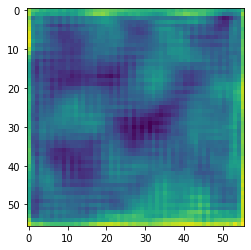

In [11]:
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

### Test Discriminator

In [12]:
image_shape = (56,56,IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.67447144]], shape=(1, 1), dtype=float32)


### Loss Function

In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### Optimizer

In [14]:
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

### Training Loop

In [15]:
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))

    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, discriminator.trainable_variables))

  return gen_loss, disc_loss

### Visualise Training Output After Each Epoch

In [2]:
import imageio
from IPython.display import Image as JupyterImage

def save_gif(tag):
  PATH = DATA_PATH + '/' + tag
  images_to_gif = []

  for filename in os.listdir(PATH):
      images_to_gif.append(imageio.imread(PATH + '/' + filename))

  imageio.mimsave(PATH + '/training_visual.gif', images_to_gif)
  print("Gif saved to ", PATH + '/training_visual.gif', images_to_gif)


### Model Train Function

In [16]:
import time
from tqdm import tqdm

def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

def train(dataset, epochs, tag):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, 
                                       SEED_SIZE))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in tqdm(dataset):
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'\nEpoch {epoch+1}, gen loss={g_loss},disc loss={d_loss}, {hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed, tag)

  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')

## Training Data


In [17]:
import numpy as np
from PIL import Image

def get_training_set(path, show_image=False):
  training_data = []

  for image in tqdm(path):
    # Convert all png's to rgb, because some don't have alpha channel
    pic = Image.open(image).convert('RGB')

    if pic.size != (56, 56):
      pic = pic.resize((56, 56))

    training_data.append(np.asarray(pic))

  training_data = np.reshape(training_data,(-1, 56, 56, IMAGE_CHANNELS))
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1.

  print("Shape of Array: ", training_data.shape)
  
  if show_image:
    # Display first 25 images
    plt.figure(1, figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(((training_data[i])/2)+0.5)
        plt.axis('off')
    plt.show()

  train_dataset = tf.data.Dataset.from_tensor_slices(training_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

  return train_dataset

In [18]:
import glob

tag_wise_paths = []
for tag in tags:
  path = f'image/{tag}/*.png'
  image_paths = glob.glob(path)
  tag_wise_paths.append((tag, len(image_paths), image_paths))

# 0 : tag, 1 : count, 2 : list of images
tag_wise_paths.sort(key=lambda x: x[1], reverse=True)

In [ ]:
for tag, count, _ in tag_wise_paths:
  print(tag, count)

## Train Network



### Trains on tag 'love'

Trains only for the first tag (love). Can be extended to run on all tags by removing the [:1] from the for loop declaration.

In [ ]:
for tag, _, paths in tag_wise_paths[:1]:
  print("***********************************************************")
  print("Tag : ", tag)
  print("Pre processing dataset")
  dataset = get_training_set(paths)
  print("Training Model")
  train(dataset, EPOCHS, tag)
  print("Showing Training Gif")
  save_gif(tag)
  print("***********************************************************")

***********************************************************
Tag :  love
Pre processing dataset


  0%|          | 0/3435 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
100%|██████████| 3435/3435 [00:01<00:00, 2627.18it/s]


Shape of Array:  (3435, 56, 56, 3)
Training Model


100%|██████████| 108/108 [00:18<00:00,  5.81it/s]



Epoch 1, gen loss=0.6765370965003967,disc loss=1.3603119850158691, 0:00:18.66


100%|██████████| 108/108 [00:14<00:00,  7.50it/s]



Epoch 2, gen loss=0.7293092012405396,disc loss=1.3226289749145508, 0:00:14.42


100%|██████████| 108/108 [00:14<00:00,  7.48it/s]



Epoch 3, gen loss=0.8322465419769287,disc loss=1.1909162998199463, 0:00:14.47


100%|██████████| 108/108 [00:14<00:00,  7.50it/s]



Epoch 4, gen loss=0.8223127722740173,disc loss=1.3960908651351929, 0:00:14.43


100%|██████████| 108/108 [00:14<00:00,  7.49it/s]



Epoch 5, gen loss=0.7313626408576965,disc loss=1.3557043075561523, 0:00:14.44


100%|██████████| 108/108 [00:14<00:00,  7.46it/s]



Epoch 6, gen loss=0.761777400970459,disc loss=1.2975599765777588, 0:00:14.49


100%|██████████| 108/108 [00:14<00:00,  7.38it/s]



Epoch 7, gen loss=0.7739785313606262,disc loss=1.2832077741622925, 0:00:14.66


100%|██████████| 108/108 [00:14<00:00,  7.39it/s]



Epoch 8, gen loss=0.7788207530975342,disc loss=1.2054933309555054, 0:00:14.64


100%|██████████| 108/108 [00:14<00:00,  7.38it/s]



Epoch 9, gen loss=0.7807772755622864,disc loss=1.2335824966430664, 0:00:14.65


100%|██████████| 108/108 [00:14<00:00,  7.38it/s]



Epoch 10, gen loss=0.778300404548645,disc loss=1.2958563566207886, 0:00:14.65


100%|██████████| 108/108 [00:14<00:00,  7.38it/s]



Epoch 11, gen loss=0.7850022912025452,disc loss=1.2750639915466309, 0:00:14.66


100%|██████████| 108/108 [00:14<00:00,  7.39it/s]



Epoch 12, gen loss=0.7857807874679565,disc loss=1.252371072769165, 0:00:14.64


100%|██████████| 108/108 [00:14<00:00,  7.38it/s]



Epoch 13, gen loss=0.7844100594520569,disc loss=1.244079828262329, 0:00:14.65


100%|██████████| 108/108 [00:14<00:00,  7.38it/s]



Epoch 14, gen loss=0.7901238203048706,disc loss=1.240791916847229, 0:00:14.67


100%|██████████| 108/108 [00:14<00:00,  7.38it/s]



Epoch 15, gen loss=0.7949215173721313,disc loss=1.2473492622375488, 0:00:14.66


100%|██████████| 108/108 [00:14<00:00,  7.38it/s]



Epoch 16, gen loss=0.8047141432762146,disc loss=1.2414239645004272, 0:00:14.66


100%|██████████| 108/108 [00:14<00:00,  7.39it/s]



Epoch 17, gen loss=0.8262768983840942,disc loss=1.199394702911377, 0:00:14.63


100%|██████████| 108/108 [00:14<00:00,  7.39it/s]



Epoch 18, gen loss=0.8361887335777283,disc loss=1.1788856983184814, 0:00:14.64


100%|██████████| 108/108 [00:14<00:00,  7.39it/s]



Epoch 19, gen loss=0.8598639369010925,disc loss=1.139315128326416, 0:00:14.64


100%|██████████| 108/108 [00:14<00:00,  7.39it/s]



Epoch 20, gen loss=0.8809762597084045,disc loss=1.147445559501648, 0:00:14.63


100%|██████████| 108/108 [00:14<00:00,  7.40it/s]



Epoch 21, gen loss=0.9020079374313354,disc loss=1.1198205947875977, 0:00:14.62


100%|██████████| 108/108 [00:14<00:00,  7.38it/s]



Epoch 22, gen loss=0.9286372065544128,disc loss=1.0937217473983765, 0:00:14.65


100%|██████████| 108/108 [00:14<00:00,  7.39it/s]



Epoch 23, gen loss=0.9243394136428833,disc loss=1.0831815004348755, 0:00:14.64


100%|██████████| 108/108 [00:20<00:00,  5.26it/s]



Epoch 24, gen loss=0.9559876918792725,disc loss=1.0600916147232056, 0:00:20.57


100%|██████████| 108/108 [00:14<00:00,  7.35it/s]



Epoch 25, gen loss=0.9577072858810425,disc loss=1.0737664699554443, 0:00:14.71


100%|██████████| 108/108 [00:14<00:00,  7.41it/s]



Epoch 26, gen loss=0.9774994850158691,disc loss=1.065415382385254, 0:00:14.59


100%|██████████| 108/108 [00:20<00:00,  5.26it/s]



Epoch 27, gen loss=0.9887354969978333,disc loss=1.0476889610290527, 0:00:20.57


100%|██████████| 108/108 [00:14<00:00,  7.36it/s]



Epoch 28, gen loss=0.9941213130950928,disc loss=1.036390781402588, 0:00:14.70


100%|██████████| 108/108 [00:20<00:00,  5.25it/s]



Epoch 29, gen loss=1.0181962251663208,disc loss=1.0194271802902222, 0:00:20.58


100%|██████████| 108/108 [00:14<00:00,  7.46it/s]



Epoch 30, gen loss=1.0252457857131958,disc loss=1.0178662538528442, 0:00:14.51


100%|██████████| 108/108 [00:14<00:00,  7.43it/s]



Epoch 31, gen loss=1.0443873405456543,disc loss=0.990415632724762, 0:00:14.56


100%|██████████| 108/108 [00:14<00:00,  7.44it/s]



Epoch 32, gen loss=1.0665313005447388,disc loss=0.9814961552619934, 0:00:14.54


100%|██████████| 108/108 [00:14<00:00,  7.42it/s]



Epoch 33, gen loss=1.0841253995895386,disc loss=0.9479272365570068, 0:00:14.57


100%|██████████| 108/108 [00:14<00:00,  7.43it/s]



Epoch 34, gen loss=1.0973085165023804,disc loss=0.9486899375915527, 0:00:14.56


100%|██████████| 108/108 [00:14<00:00,  7.39it/s]



Epoch 35, gen loss=1.1140520572662354,disc loss=0.9390512108802795, 0:00:14.63


100%|██████████| 108/108 [00:14<00:00,  7.38it/s]



Epoch 36, gen loss=1.1404774188995361,disc loss=0.9081788063049316, 0:00:14.65


100%|██████████| 108/108 [00:14<00:00,  7.40it/s]



Epoch 37, gen loss=1.1580995321273804,disc loss=0.9033938050270081, 0:00:14.62


100%|██████████| 108/108 [00:20<00:00,  5.26it/s]



Epoch 38, gen loss=1.170984148979187,disc loss=0.871654212474823, 0:00:20.57


100%|██████████| 108/108 [00:14<00:00,  7.33it/s]



Epoch 39, gen loss=1.212491512298584,disc loss=0.845293402671814, 0:00:14.77


100%|██████████| 108/108 [00:14<00:00,  7.38it/s]



Epoch 40, gen loss=1.2269377708435059,disc loss=0.8316141963005066, 0:00:14.65


100%|██████████| 108/108 [00:20<00:00,  5.25it/s]



Epoch 41, gen loss=1.2628575563430786,disc loss=0.810575544834137, 0:00:20.58


100%|██████████| 108/108 [00:14<00:00,  7.32it/s]



Epoch 42, gen loss=1.2739241123199463,disc loss=0.8024876713752747, 0:00:14.79


100%|██████████| 108/108 [00:14<00:00,  7.39it/s]



Epoch 43, gen loss=1.294495701789856,disc loss=0.7984396815299988, 0:00:14.64


100%|██████████| 108/108 [00:14<00:00,  7.40it/s]



Epoch 44, gen loss=1.3238449096679688,disc loss=0.7736958861351013, 0:00:14.61


100%|██████████| 108/108 [00:14<00:00,  7.40it/s]



Epoch 45, gen loss=1.3573744297027588,disc loss=0.7227402329444885, 0:00:14.61


100%|██████████| 108/108 [00:14<00:00,  7.38it/s]



Epoch 46, gen loss=1.386939287185669,disc loss=0.7128311991691589, 0:00:14.66


100%|██████████| 108/108 [00:14<00:00,  7.37it/s]



Epoch 47, gen loss=1.4098883867263794,disc loss=0.7006255984306335, 0:00:14.68


100%|██████████| 108/108 [00:14<00:00,  7.38it/s]



Epoch 48, gen loss=1.4291177988052368,disc loss=0.7059481143951416, 0:00:14.66


100%|██████████| 108/108 [00:14<00:00,  7.38it/s]



Epoch 49, gen loss=1.4553910493850708,disc loss=0.6841526627540588, 0:00:14.65


100%|██████████| 108/108 [00:14<00:00,  7.38it/s]



Epoch 50, gen loss=1.4832507371902466,disc loss=0.6730744242668152, 0:00:14.65


100%|██████████| 108/108 [00:14<00:00,  7.38it/s]



Epoch 51, gen loss=1.5216656923294067,disc loss=0.6278719305992126, 0:00:14.65


100%|██████████| 108/108 [00:20<00:00,  5.26it/s]



Epoch 52, gen loss=1.547869086265564,disc loss=0.6171577572822571, 0:00:20.57


100%|██████████| 108/108 [00:14<00:00,  7.35it/s]



Epoch 53, gen loss=1.572447657585144,disc loss=0.6117221713066101, 0:00:14.72


100%|██████████| 108/108 [00:14<00:00,  7.40it/s]



Epoch 54, gen loss=1.6050087213516235,disc loss=0.5829992890357971, 0:00:14.62


100%|██████████| 108/108 [00:14<00:00,  7.41it/s]



Epoch 55, gen loss=1.6251001358032227,disc loss=0.581824779510498, 0:00:14.61


100%|██████████| 108/108 [00:14<00:00,  7.39it/s]



Epoch 56, gen loss=1.6467605829238892,disc loss=0.5744355320930481, 0:00:14.64


100%|██████████| 108/108 [00:14<00:00,  7.41it/s]



Epoch 57, gen loss=1.6874598264694214,disc loss=0.541912317276001, 0:00:14.60


100%|██████████| 108/108 [00:14<00:00,  7.40it/s]



Epoch 58, gen loss=1.7101651430130005,disc loss=0.5319868922233582, 0:00:14.63


100%|██████████| 108/108 [00:14<00:00,  7.40it/s]



Epoch 59, gen loss=1.7596442699432373,disc loss=0.5011715888977051, 0:00:14.61


100%|██████████| 108/108 [00:14<00:00,  7.41it/s]



Epoch 60, gen loss=1.7674027681350708,disc loss=0.5224255919456482, 0:00:14.59


100%|██████████| 108/108 [00:14<00:00,  7.45it/s]



Epoch 61, gen loss=1.7974478006362915,disc loss=0.4903678596019745, 0:00:14.52


100%|██████████| 108/108 [00:14<00:00,  7.41it/s]



Epoch 62, gen loss=1.8353271484375,disc loss=0.4755641222000122, 0:00:14.59


100%|██████████| 108/108 [00:14<00:00,  7.44it/s]



Epoch 63, gen loss=1.8340438604354858,disc loss=0.48592451214790344, 0:00:14.55


100%|██████████| 108/108 [00:14<00:00,  7.45it/s]



Epoch 64, gen loss=1.8862334489822388,disc loss=0.4445333778858185, 0:00:14.51


100%|██████████| 108/108 [00:14<00:00,  7.41it/s]



Epoch 65, gen loss=1.91056227684021,disc loss=0.44809654355049133, 0:00:14.60


100%|██████████| 108/108 [00:14<00:00,  7.40it/s]



Epoch 66, gen loss=1.938602328300476,disc loss=0.4335399270057678, 0:00:14.62


100%|██████████| 108/108 [00:20<00:00,  5.26it/s]



Epoch 67, gen loss=1.966472864151001,disc loss=0.41617584228515625, 0:00:20.57


100%|██████████| 108/108 [00:14<00:00,  7.39it/s]



Epoch 68, gen loss=2.0093770027160645,disc loss=0.39167556166648865, 0:00:14.65


100%|██████████| 108/108 [00:14<00:00,  7.41it/s]



Epoch 69, gen loss=2.0251941680908203,disc loss=0.40457993745803833, 0:00:14.59


100%|██████████| 108/108 [00:14<00:00,  7.41it/s]



Epoch 70, gen loss=2.0345101356506348,disc loss=0.40535908937454224, 0:00:14.60


100%|██████████| 108/108 [00:14<00:00,  7.38it/s]



Epoch 71, gen loss=2.0712530612945557,disc loss=0.3800278306007385, 0:00:14.65


100%|██████████| 108/108 [00:14<00:00,  7.40it/s]



Epoch 72, gen loss=2.0993425846099854,disc loss=0.3754194974899292, 0:00:14.61


100%|██████████| 108/108 [00:14<00:00,  7.38it/s]



Epoch 73, gen loss=2.1320078372955322,disc loss=0.3647816479206085, 0:00:14.65


100%|██████████| 108/108 [00:14<00:00,  7.40it/s]



Epoch 74, gen loss=2.15976619720459,disc loss=0.35366928577423096, 0:00:14.63


100%|██████████| 108/108 [00:14<00:00,  7.39it/s]



Epoch 75, gen loss=2.180804491043091,disc loss=0.34865301847457886, 0:00:14.64


100%|██████████| 108/108 [00:20<00:00,  5.26it/s]



Epoch 76, gen loss=2.2077279090881348,disc loss=0.3382158577442169, 0:00:20.57


100%|██████████| 108/108 [00:14<00:00,  7.34it/s]



Epoch 77, gen loss=2.2386224269866943,disc loss=0.32943883538246155, 0:00:14.75


100%|██████████| 108/108 [00:20<00:00,  5.26it/s]



Epoch 78, gen loss=2.26471209526062,disc loss=0.3229259252548218, 0:00:20.57


100%|██████████| 108/108 [00:20<00:00,  5.26it/s]



Epoch 79, gen loss=2.284247636795044,disc loss=0.324099600315094, 0:00:20.58


100%|██████████| 108/108 [00:14<00:00,  7.37it/s]



Epoch 80, gen loss=2.319568157196045,disc loss=0.31244799494743347, 0:00:14.68


100%|██████████| 108/108 [00:14<00:00,  7.43it/s]



Epoch 81, gen loss=2.3434760570526123,disc loss=0.3014913499355316, 0:00:14.57


100%|██████████| 108/108 [00:14<00:00,  7.41it/s]



Epoch 82, gen loss=2.372802734375,disc loss=0.295526385307312, 0:00:14.60


100%|██████████| 108/108 [00:14<00:00,  7.40it/s]



Epoch 83, gen loss=2.3790457248687744,disc loss=0.2933177351951599, 0:00:14.61


100%|██████████| 108/108 [00:20<00:00,  5.26it/s]



Epoch 84, gen loss=2.4363315105438232,disc loss=0.26627928018569946, 0:00:20.58


100%|██████████| 108/108 [00:14<00:00,  7.36it/s]



Epoch 85, gen loss=2.459022045135498,disc loss=0.2620001435279846, 0:00:14.71


100%|██████████| 108/108 [00:14<00:00,  7.40it/s]



Epoch 86, gen loss=2.4776501655578613,disc loss=0.2665921449661255, 0:00:14.61


100%|██████████| 108/108 [00:14<00:00,  7.38it/s]



Epoch 87, gen loss=2.5297818183898926,disc loss=0.2509283721446991, 0:00:14.65


100%|██████████| 108/108 [00:14<00:00,  7.39it/s]



Epoch 88, gen loss=2.544877052307129,disc loss=0.2438776195049286, 0:00:14.63


100%|██████████| 108/108 [00:14<00:00,  7.40it/s]



Epoch 89, gen loss=2.562042474746704,disc loss=0.2344488948583603, 0:00:14.62


100%|██████████| 108/108 [00:14<00:00,  7.38it/s]



Epoch 90, gen loss=2.5794789791107178,disc loss=0.25596949458122253, 0:00:14.66


100%|██████████| 108/108 [00:20<00:00,  5.26it/s]



Epoch 91, gen loss=2.6062123775482178,disc loss=0.22941094636917114, 0:00:20.57


100%|██████████| 108/108 [00:14<00:00,  7.35it/s]



Epoch 92, gen loss=2.6455342769622803,disc loss=0.22295382618904114, 0:00:14.73


100%|██████████| 108/108 [00:14<00:00,  7.42it/s]



Epoch 93, gen loss=2.6787989139556885,disc loss=0.22498778998851776, 0:00:14.59


100%|██████████| 108/108 [00:14<00:00,  7.41it/s]



Epoch 94, gen loss=2.6800832748413086,disc loss=0.22229747474193573, 0:00:14.59


100%|██████████| 108/108 [00:20<00:00,  5.26it/s]



Epoch 95, gen loss=2.6807353496551514,disc loss=0.23983901739120483, 0:00:20.57


100%|██████████| 108/108 [00:14<00:00,  7.36it/s]



Epoch 96, gen loss=2.7287607192993164,disc loss=0.2161601185798645, 0:00:14.70


100%|██████████| 108/108 [00:14<00:00,  7.42it/s]



Epoch 97, gen loss=2.751993179321289,disc loss=0.2122187316417694, 0:00:14.57


100%|██████████| 108/108 [00:20<00:00,  5.26it/s]



Epoch 98, gen loss=2.789418935775757,disc loss=0.1973985880613327, 0:00:20.58


100%|██████████| 108/108 [00:14<00:00,  7.37it/s]



Epoch 99, gen loss=2.796891212463379,disc loss=0.2096129059791565, 0:00:14.68


100%|██████████| 108/108 [00:14<00:00,  7.45it/s]



Epoch 100, gen loss=2.8262715339660645,disc loss=0.19791334867477417, 0:00:14.52


100%|██████████| 108/108 [00:14<00:00,  7.44it/s]



Epoch 101, gen loss=2.8597559928894043,disc loss=0.19038522243499756, 0:00:14.55


100%|██████████| 108/108 [00:14<00:00,  7.41it/s]



Epoch 102, gen loss=2.8712756633758545,disc loss=0.19805549085140228, 0:00:14.59


100%|██████████| 108/108 [00:14<00:00,  7.38it/s]



Epoch 103, gen loss=2.888575315475464,disc loss=0.19420045614242554, 0:00:14.66


100%|██████████| 108/108 [00:20<00:00,  5.25it/s]



Epoch 104, gen loss=2.9318363666534424,disc loss=0.17119945585727692, 0:00:20.58


100%|██████████| 108/108 [00:14<00:00,  7.34it/s]



Epoch 105, gen loss=2.94551682472229,disc loss=0.18191994726657867, 0:00:14.74


100%|██████████| 108/108 [00:14<00:00,  7.41it/s]



Epoch 106, gen loss=2.9657461643218994,disc loss=0.1805756837129593, 0:00:14.61


100%|██████████| 108/108 [00:14<00:00,  7.41it/s]



Epoch 107, gen loss=2.9988694190979004,disc loss=0.1726698875427246, 0:00:14.60


100%|██████████| 108/108 [00:14<00:00,  7.43it/s]



Epoch 108, gen loss=3.003892660140991,disc loss=0.19025392830371857, 0:00:14.58


100%|██████████| 108/108 [00:14<00:00,  7.41it/s]



Epoch 109, gen loss=3.040311098098755,disc loss=0.1634538471698761, 0:00:14.60


100%|██████████| 108/108 [00:20<00:00,  5.26it/s]



Epoch 110, gen loss=3.0800862312316895,disc loss=0.15547560155391693, 0:00:20.57


100%|██████████| 108/108 [00:14<00:00,  7.41it/s]



Epoch 111, gen loss=3.077514410018921,disc loss=0.16870743036270142, 0:00:14.60


100%|██████████| 108/108 [00:14<00:00,  7.41it/s]



Epoch 112, gen loss=3.0784947872161865,disc loss=0.1714380383491516, 0:00:14.60


100%|██████████| 108/108 [00:14<00:00,  7.41it/s]



Epoch 113, gen loss=3.10772442817688,disc loss=0.17203277349472046, 0:00:14.59


100%|██████████| 108/108 [00:14<00:00,  7.39it/s]



Epoch 114, gen loss=3.1619861125946045,disc loss=0.14762865006923676, 0:00:14.63


100%|██████████| 108/108 [00:14<00:00,  7.40it/s]



Epoch 115, gen loss=3.1491596698760986,disc loss=0.16834953427314758, 0:00:14.61


100%|██████████| 108/108 [00:14<00:00,  7.38it/s]



Epoch 116, gen loss=3.1860809326171875,disc loss=0.15867656469345093, 0:00:14.66


100%|██████████| 108/108 [00:14<00:00,  7.39it/s]



Epoch 117, gen loss=3.213658094406128,disc loss=0.15042437613010406, 0:00:14.65


100%|██████████| 108/108 [00:14<00:00,  7.37it/s]



Epoch 118, gen loss=3.228144645690918,disc loss=0.15103070437908173, 0:00:14.68


100%|██████████| 108/108 [00:14<00:00,  7.39it/s]



Epoch 119, gen loss=3.2289743423461914,disc loss=0.1662990003824234, 0:00:14.64


100%|██████████| 108/108 [00:14<00:00,  7.37it/s]



Epoch 120, gen loss=3.2928149700164795,disc loss=0.138010635972023, 0:00:14.68


100%|██████████| 108/108 [00:14<00:00,  7.36it/s]



Epoch 121, gen loss=3.3027079105377197,disc loss=0.1373380571603775, 0:00:14.71


100%|██████████| 108/108 [00:14<00:00,  7.40it/s]



Epoch 122, gen loss=3.32053279876709,disc loss=0.14072205126285553, 0:00:14.64


100%|██████████| 108/108 [00:14<00:00,  7.38it/s]



Epoch 123, gen loss=3.3566701412200928,disc loss=0.1357339769601822, 0:00:14.66


100%|██████████| 108/108 [00:14<00:00,  7.39it/s]



Epoch 124, gen loss=3.3264384269714355,disc loss=0.15684166550636292, 0:00:14.65


100%|██████████| 108/108 [00:14<00:00,  7.38it/s]



Epoch 125, gen loss=3.370023727416992,disc loss=0.13723473250865936, 0:00:14.66


100%|██████████| 108/108 [00:14<00:00,  7.42it/s]



Epoch 126, gen loss=3.396116018295288,disc loss=0.13839609920978546, 0:00:14.58


100%|██████████| 108/108 [00:14<00:00,  7.39it/s]



Epoch 127, gen loss=3.4344379901885986,disc loss=0.12107447534799576, 0:00:14.64


100%|██████████| 108/108 [00:14<00:00,  7.40it/s]



Epoch 128, gen loss=3.4589550495147705,disc loss=0.11981724947690964, 0:00:14.63


100%|██████████| 108/108 [00:14<00:00,  7.39it/s]



Epoch 129, gen loss=3.477444648742676,disc loss=0.1284339278936386, 0:00:14.66


100%|██████████| 108/108 [00:14<00:00,  7.40it/s]



Epoch 130, gen loss=3.487147569656372,disc loss=0.12258350104093552, 0:00:14.63


100%|██████████| 108/108 [00:14<00:00,  7.39it/s]



Epoch 131, gen loss=3.5250444412231445,disc loss=0.11631930619478226, 0:00:14.64


100%|██████████| 108/108 [00:20<00:00,  5.25it/s]



Epoch 132, gen loss=3.5218656063079834,disc loss=0.1256551891565323, 0:00:20.58


100%|██████████| 108/108 [00:14<00:00,  7.37it/s]



Epoch 133, gen loss=3.5392229557037354,disc loss=0.11896643787622452, 0:00:14.68


100%|██████████| 108/108 [00:14<00:00,  7.40it/s]



Epoch 134, gen loss=3.5715301036834717,disc loss=0.12599341571331024, 0:00:14.62


100%|██████████| 108/108 [00:14<00:00,  7.40it/s]



Epoch 135, gen loss=3.5738766193389893,disc loss=0.12097544223070145, 0:00:14.62


100%|██████████| 108/108 [00:14<00:00,  7.41it/s]



Epoch 136, gen loss=3.572754144668579,disc loss=0.13407954573631287, 0:00:14.59


100%|██████████| 108/108 [00:14<00:00,  7.42it/s]



Epoch 137, gen loss=3.635711431503296,disc loss=0.10321391373872757, 0:00:14.58


100%|██████████| 108/108 [00:14<00:00,  7.40it/s]



Epoch 138, gen loss=3.6280789375305176,disc loss=0.11452679336071014, 0:00:14.63


100%|██████████| 108/108 [00:14<00:00,  7.43it/s]



Epoch 139, gen loss=3.6892669200897217,disc loss=0.098124660551548, 0:00:14.57


100%|██████████| 108/108 [00:14<00:00,  7.42it/s]



Epoch 140, gen loss=3.642551898956299,disc loss=0.12321332842111588, 0:00:14.59


100%|██████████| 108/108 [00:20<00:00,  5.26it/s]



Epoch 141, gen loss=3.698164939880371,disc loss=0.11784522980451584, 0:00:20.58


100%|██████████| 108/108 [00:14<00:00,  7.35it/s]



Epoch 142, gen loss=3.7002243995666504,disc loss=0.11823403090238571, 0:00:14.72


100%|██████████| 108/108 [00:14<00:00,  7.41it/s]



Epoch 143, gen loss=3.717829704284668,disc loss=0.11552640795707703, 0:00:14.60


100%|██████████| 108/108 [00:14<00:00,  7.38it/s]



Epoch 144, gen loss=3.740483283996582,disc loss=0.10936519503593445, 0:00:14.66


100%|██████████| 108/108 [00:14<00:00,  7.41it/s]



Epoch 145, gen loss=3.807237148284912,disc loss=0.09073701500892639, 0:00:14.61


100%|██████████| 108/108 [00:14<00:00,  7.40it/s]



Epoch 146, gen loss=3.816176414489746,disc loss=0.09208966791629791, 0:00:14.63


100%|██████████| 108/108 [00:14<00:00,  7.42it/s]



Epoch 147, gen loss=3.8261501789093018,disc loss=0.10221018642187119, 0:00:14.58


100%|██████████| 108/108 [00:20<00:00,  5.26it/s]



Epoch 148, gen loss=3.8435134887695312,disc loss=0.10219158977270126, 0:00:20.58


100%|██████████| 108/108 [00:14<00:00,  7.32it/s]



Epoch 149, gen loss=3.846536874771118,disc loss=0.1034756675362587, 0:00:14.78


100%|██████████| 108/108 [00:14<00:00,  7.42it/s]



Epoch 150, gen loss=3.887502908706665,disc loss=0.09019394963979721, 0:00:14.57


100%|██████████| 108/108 [00:14<00:00,  7.49it/s]



Epoch 151, gen loss=3.923496961593628,disc loss=0.08069558441638947, 0:00:14.45


100%|██████████| 108/108 [00:14<00:00,  7.54it/s]



Epoch 152, gen loss=3.9471359252929688,disc loss=0.08839181810617447, 0:00:14.34


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 153, gen loss=3.9372849464416504,disc loss=0.09141603857278824, 0:00:14.33


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 154, gen loss=3.960571050643921,disc loss=0.08598261326551437, 0:00:14.31


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 155, gen loss=3.983652114868164,disc loss=0.0853872150182724, 0:00:14.31


100%|██████████| 108/108 [00:20<00:00,  5.26it/s]



Epoch 156, gen loss=4.007980823516846,disc loss=0.08971064537763596, 0:00:20.58


100%|██████████| 108/108 [00:20<00:00,  5.26it/s]



Epoch 157, gen loss=4.014923572540283,disc loss=0.08778730034828186, 0:00:20.58


100%|██████████| 108/108 [00:14<00:00,  7.51it/s]



Epoch 158, gen loss=4.005092144012451,disc loss=0.09340836107730865, 0:00:14.42


100%|██████████| 108/108 [00:20<00:00,  5.25it/s]



Epoch 159, gen loss=4.021426677703857,disc loss=0.09085539728403091, 0:00:20.58


100%|██████████| 108/108 [00:14<00:00,  7.49it/s]



Epoch 160, gen loss=4.055499076843262,disc loss=0.0925155058503151, 0:00:14.46


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 161, gen loss=4.077654838562012,disc loss=0.08339438587427139, 0:00:14.28


100%|██████████| 108/108 [00:14<00:00,  7.55it/s]



Epoch 162, gen loss=4.097230911254883,disc loss=0.0686710998415947, 0:00:14.34


100%|██████████| 108/108 [00:14<00:00,  7.58it/s]



Epoch 163, gen loss=4.124509334564209,disc loss=0.07942868024110794, 0:00:14.27


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 164, gen loss=4.141520977020264,disc loss=0.0766085609793663, 0:00:14.29


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 165, gen loss=4.170491695404053,disc loss=0.07671468704938889, 0:00:14.31


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 166, gen loss=4.146103382110596,disc loss=0.08732957392930984, 0:00:14.29


100%|██████████| 108/108 [00:20<00:00,  5.26it/s]



Epoch 167, gen loss=4.192708969116211,disc loss=0.07049177587032318, 0:00:20.58


100%|██████████| 108/108 [00:14<00:00,  7.49it/s]



Epoch 168, gen loss=4.230101108551025,disc loss=0.07330566644668579, 0:00:14.45


100%|██████████| 108/108 [00:14<00:00,  7.58it/s]



Epoch 169, gen loss=4.246993541717529,disc loss=0.0689229965209961, 0:00:14.27


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 170, gen loss=4.2640275955200195,disc loss=0.07045572996139526, 0:00:14.31


100%|██████████| 108/108 [00:14<00:00,  7.59it/s]



Epoch 171, gen loss=4.2567033767700195,disc loss=0.08098138868808746, 0:00:14.26


100%|██████████| 108/108 [00:14<00:00,  7.58it/s]



Epoch 172, gen loss=4.254887104034424,disc loss=0.08373001217842102, 0:00:14.27


100%|██████████| 108/108 [00:14<00:00,  7.58it/s]



Epoch 173, gen loss=4.278273582458496,disc loss=0.08145495504140854, 0:00:14.27


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 174, gen loss=4.294912815093994,disc loss=0.08083392679691315, 0:00:14.29


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 175, gen loss=4.31942081451416,disc loss=0.07220479100942612, 0:00:14.30


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 176, gen loss=4.326451301574707,disc loss=0.06327682733535767, 0:00:14.31


100%|██████████| 108/108 [00:14<00:00,  7.55it/s]



Epoch 177, gen loss=4.34542989730835,disc loss=0.07975056767463684, 0:00:14.32


100%|██████████| 108/108 [00:14<00:00,  7.55it/s]



Epoch 178, gen loss=4.390682220458984,disc loss=0.06617366522550583, 0:00:14.34


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 179, gen loss=4.394073009490967,disc loss=0.06688079982995987, 0:00:14.32


100%|██████████| 108/108 [00:14<00:00,  7.55it/s]



Epoch 180, gen loss=4.399601459503174,disc loss=0.06644114851951599, 0:00:14.33


100%|██████████| 108/108 [00:14<00:00,  7.55it/s]



Epoch 181, gen loss=4.421722888946533,disc loss=0.06162458285689354, 0:00:14.33


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 182, gen loss=4.410153388977051,disc loss=0.08675937354564667, 0:00:14.31


100%|██████████| 108/108 [00:14<00:00,  7.54it/s]



Epoch 183, gen loss=4.396494388580322,disc loss=0.07922463119029999, 0:00:14.36


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 184, gen loss=4.458264350891113,disc loss=0.07212362438440323, 0:00:14.31


100%|██████████| 108/108 [00:14<00:00,  7.55it/s]



Epoch 185, gen loss=4.428678035736084,disc loss=0.08276113122701645, 0:00:14.32


100%|██████████| 108/108 [00:14<00:00,  7.55it/s]



Epoch 186, gen loss=4.511638641357422,disc loss=0.06479647755622864, 0:00:14.33


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 187, gen loss=4.50750207901001,disc loss=0.06030571460723877, 0:00:14.32


100%|██████████| 108/108 [00:14<00:00,  7.54it/s]



Epoch 188, gen loss=4.471281051635742,disc loss=0.08015602827072144, 0:00:14.35


100%|██████████| 108/108 [00:14<00:00,  7.55it/s]



Epoch 189, gen loss=4.504484176635742,disc loss=0.0627535730600357, 0:00:14.33


100%|██████████| 108/108 [00:14<00:00,  7.55it/s]



Epoch 190, gen loss=4.542373180389404,disc loss=0.07484737783670425, 0:00:14.33


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 191, gen loss=4.562898635864258,disc loss=0.06027250364422798, 0:00:14.31


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 192, gen loss=4.585505962371826,disc loss=0.0638800859451294, 0:00:14.32


100%|██████████| 108/108 [00:14<00:00,  7.55it/s]



Epoch 193, gen loss=4.5626726150512695,disc loss=0.0712185800075531, 0:00:14.32


100%|██████████| 108/108 [00:14<00:00,  7.54it/s]



Epoch 194, gen loss=4.601935863494873,disc loss=0.0702086091041565, 0:00:14.35


100%|██████████| 108/108 [00:14<00:00,  7.54it/s]



Epoch 195, gen loss=4.636691093444824,disc loss=0.06165231019258499, 0:00:14.35


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 196, gen loss=4.628149032592773,disc loss=0.06355325132608414, 0:00:14.31


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 197, gen loss=4.6323771476745605,disc loss=0.06362801790237427, 0:00:14.30


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 198, gen loss=4.65213680267334,disc loss=0.06044674292206764, 0:00:14.31


100%|██████████| 108/108 [00:20<00:00,  5.25it/s]



Epoch 199, gen loss=4.66203498840332,disc loss=0.054289810359478, 0:00:20.58


100%|██████████| 108/108 [00:14<00:00,  7.47it/s]



Epoch 200, gen loss=4.697484493255615,disc loss=0.057895347476005554, 0:00:14.49


100%|██████████| 108/108 [00:20<00:00,  5.25it/s]



Epoch 201, gen loss=4.717127799987793,disc loss=0.05053865164518356, 0:00:20.58


100%|██████████| 108/108 [00:14<00:00,  7.52it/s]



Epoch 202, gen loss=4.74193000793457,disc loss=0.05390693619847298, 0:00:14.39


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 203, gen loss=4.759381294250488,disc loss=0.052815817296504974, 0:00:14.31


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 204, gen loss=4.780642032623291,disc loss=0.04679445922374725, 0:00:14.30


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 205, gen loss=4.738180637359619,disc loss=0.06898918747901917, 0:00:14.31


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 206, gen loss=4.75360107421875,disc loss=0.056112345308065414, 0:00:14.32


100%|██████████| 108/108 [00:20<00:00,  5.25it/s]



Epoch 207, gen loss=4.79548454284668,disc loss=0.057150475680828094, 0:00:20.59


100%|██████████| 108/108 [00:20<00:00,  5.25it/s]



Epoch 208, gen loss=4.7853312492370605,disc loss=0.05167841166257858, 0:00:20.59


100%|██████████| 108/108 [00:14<00:00,  7.54it/s]



Epoch 209, gen loss=4.824364185333252,disc loss=0.05369194224476814, 0:00:14.36


100%|██████████| 108/108 [00:14<00:00,  7.59it/s]



Epoch 210, gen loss=4.798722267150879,disc loss=0.059690628200769424, 0:00:14.28


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 211, gen loss=4.841891288757324,disc loss=0.05654275044798851, 0:00:14.32


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 212, gen loss=4.8145928382873535,disc loss=0.05592631548643112, 0:00:14.29


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 213, gen loss=4.855608940124512,disc loss=0.044494304805994034, 0:00:14.30


100%|██████████| 108/108 [00:14<00:00,  7.54it/s]



Epoch 214, gen loss=4.845564842224121,disc loss=0.06674450635910034, 0:00:14.36


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 215, gen loss=4.861708641052246,disc loss=0.04949570074677467, 0:00:14.31


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 216, gen loss=4.887308120727539,disc loss=0.05651729926466942, 0:00:14.31


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 217, gen loss=4.872424125671387,disc loss=0.052556391805410385, 0:00:14.30


100%|██████████| 108/108 [00:14<00:00,  7.53it/s]



Epoch 218, gen loss=4.916460037231445,disc loss=0.04731924831867218, 0:00:14.37


100%|██████████| 108/108 [00:14<00:00,  7.55it/s]



Epoch 219, gen loss=4.908552169799805,disc loss=0.05606932193040848, 0:00:14.32


100%|██████████| 108/108 [00:14<00:00,  7.58it/s]



Epoch 220, gen loss=4.916926860809326,disc loss=0.05151231586933136, 0:00:14.28


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 221, gen loss=4.9084696769714355,disc loss=0.06178887560963631, 0:00:14.30


100%|██████████| 108/108 [00:14<00:00,  7.59it/s]



Epoch 222, gen loss=4.970692157745361,disc loss=0.05231508985161781, 0:00:14.27


100%|██████████| 108/108 [00:14<00:00,  7.59it/s]



Epoch 223, gen loss=5.0042033195495605,disc loss=0.04232276231050491, 0:00:14.26


100%|██████████| 108/108 [00:14<00:00,  7.60it/s]



Epoch 224, gen loss=4.947832107543945,disc loss=0.05676279962062836, 0:00:14.24


100%|██████████| 108/108 [00:14<00:00,  7.58it/s]



Epoch 225, gen loss=5.010091304779053,disc loss=0.041458845138549805, 0:00:14.29


100%|██████████| 108/108 [00:14<00:00,  7.58it/s]



Epoch 226, gen loss=5.013754367828369,disc loss=0.06036835163831711, 0:00:14.29


100%|██████████| 108/108 [00:14<00:00,  7.53it/s]



Epoch 227, gen loss=5.010162830352783,disc loss=0.055917855352163315, 0:00:14.38


100%|██████████| 108/108 [00:14<00:00,  7.54it/s]



Epoch 228, gen loss=5.0285515785217285,disc loss=0.05434165522456169, 0:00:14.35


100%|██████████| 108/108 [00:20<00:00,  5.26it/s]



Epoch 229, gen loss=5.014267444610596,disc loss=0.05081716552376747, 0:00:20.58


100%|██████████| 108/108 [00:14<00:00,  7.46it/s]



Epoch 230, gen loss=5.042917251586914,disc loss=0.044977687299251556, 0:00:14.51


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 231, gen loss=5.057756423950195,disc loss=0.03952879086136818, 0:00:14.31


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 232, gen loss=5.049107074737549,disc loss=0.05162877216935158, 0:00:14.31


100%|██████████| 108/108 [00:14<00:00,  7.55it/s]



Epoch 233, gen loss=5.089788913726807,disc loss=0.04254910349845886, 0:00:14.34


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 234, gen loss=5.064620018005371,disc loss=0.0533289909362793, 0:00:14.32


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 235, gen loss=5.1208720207214355,disc loss=0.044048044830560684, 0:00:14.31


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 236, gen loss=5.11322021484375,disc loss=0.050005894154310226, 0:00:14.31


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 237, gen loss=5.132384300231934,disc loss=0.04286692291498184, 0:00:14.33


100%|██████████| 108/108 [00:20<00:00,  5.26it/s]



Epoch 238, gen loss=5.107473850250244,disc loss=0.062906913459301, 0:00:20.59


100%|██████████| 108/108 [00:14<00:00,  7.47it/s]



Epoch 239, gen loss=5.143811225891113,disc loss=0.05513819679617882, 0:00:14.49


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 240, gen loss=5.147815704345703,disc loss=0.045151062309741974, 0:00:14.30


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 241, gen loss=5.145476341247559,disc loss=0.049435559660196304, 0:00:14.30


100%|██████████| 108/108 [00:14<00:00,  7.54it/s]



Epoch 242, gen loss=5.1348700523376465,disc loss=0.06356347352266312, 0:00:14.36


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 243, gen loss=5.16096305847168,disc loss=0.05319332331418991, 0:00:14.31


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 244, gen loss=5.125603675842285,disc loss=0.06080291047692299, 0:00:14.31


100%|██████████| 108/108 [00:14<00:00,  7.58it/s]



Epoch 245, gen loss=5.149713039398193,disc loss=0.04791460186243057, 0:00:14.28


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 246, gen loss=5.177724838256836,disc loss=0.046409972012043, 0:00:14.32


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 247, gen loss=5.1849212646484375,disc loss=0.04479139298200607, 0:00:14.30


100%|██████████| 108/108 [00:14<00:00,  7.59it/s]



Epoch 248, gen loss=5.229214191436768,disc loss=0.047839608043432236, 0:00:14.26


100%|██████████| 108/108 [00:14<00:00,  7.55it/s]



Epoch 249, gen loss=5.195302486419678,disc loss=0.043644051998853683, 0:00:14.36


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 250, gen loss=5.225537300109863,disc loss=0.039148908108472824, 0:00:14.31


100%|██████████| 108/108 [00:14<00:00,  7.55it/s]



Epoch 251, gen loss=5.229827404022217,disc loss=0.038866009563207626, 0:00:14.34


100%|██████████| 108/108 [00:20<00:00,  5.26it/s]



Epoch 252, gen loss=5.256379127502441,disc loss=0.026819275692105293, 0:00:20.59


100%|██████████| 108/108 [00:14<00:00,  7.45it/s]



Epoch 253, gen loss=5.246854782104492,disc loss=0.04168979823589325, 0:00:14.53


100%|██████████| 108/108 [00:20<00:00,  5.25it/s]



Epoch 254, gen loss=5.228718280792236,disc loss=0.05789339914917946, 0:00:20.59


100%|██████████| 108/108 [00:20<00:00,  5.25it/s]



Epoch 255, gen loss=5.248417377471924,disc loss=0.04811124876141548, 0:00:20.61


100%|██████████| 108/108 [00:14<00:00,  7.49it/s]



Epoch 256, gen loss=5.260382175445557,disc loss=0.04422948881983757, 0:00:14.45


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 257, gen loss=5.3020243644714355,disc loss=0.03896712511777878, 0:00:14.30


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 258, gen loss=5.32738733291626,disc loss=0.039921004325151443, 0:00:14.30


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 259, gen loss=5.30824613571167,disc loss=0.04630541801452637, 0:00:14.32


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 260, gen loss=5.28851842880249,disc loss=0.0493948794901371, 0:00:14.29


100%|██████████| 108/108 [00:14<00:00,  7.54it/s]



Epoch 261, gen loss=5.325693130493164,disc loss=0.04139295220375061, 0:00:14.36


100%|██████████| 108/108 [00:14<00:00,  7.55it/s]



Epoch 262, gen loss=5.327782154083252,disc loss=0.04583670571446419, 0:00:14.32


100%|██████████| 108/108 [00:14<00:00,  7.55it/s]



Epoch 263, gen loss=5.2837090492248535,disc loss=0.052288368344306946, 0:00:14.34


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 264, gen loss=5.300320625305176,disc loss=0.057396050542593, 0:00:14.31


100%|██████████| 108/108 [00:14<00:00,  7.55it/s]



Epoch 265, gen loss=5.350179195404053,disc loss=0.05018410086631775, 0:00:14.34


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 266, gen loss=5.360874652862549,disc loss=0.0518353134393692, 0:00:14.31


100%|██████████| 108/108 [00:14<00:00,  7.54it/s]



Epoch 267, gen loss=5.291155815124512,disc loss=0.05858515948057175, 0:00:14.35


100%|██████████| 108/108 [00:20<00:00,  5.26it/s]



Epoch 268, gen loss=5.370302677154541,disc loss=0.04110435023903847, 0:00:20.57


100%|██████████| 108/108 [00:20<00:00,  5.25it/s]



Epoch 269, gen loss=5.3952813148498535,disc loss=0.02926561050117016, 0:00:20.59


100%|██████████| 108/108 [00:14<00:00,  7.50it/s]



Epoch 270, gen loss=5.403295040130615,disc loss=0.04317593201994896, 0:00:14.44


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 271, gen loss=5.395404815673828,disc loss=0.04238296300172806, 0:00:14.31


100%|██████████| 108/108 [00:14<00:00,  7.53it/s]



Epoch 272, gen loss=5.40568208694458,disc loss=0.03439601883292198, 0:00:14.38


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 273, gen loss=5.464760780334473,disc loss=0.03026752732694149, 0:00:14.31


100%|██████████| 108/108 [00:14<00:00,  7.55it/s]



Epoch 274, gen loss=5.428051948547363,disc loss=0.040505893528461456, 0:00:14.33


100%|██████████| 108/108 [00:14<00:00,  7.58it/s]



Epoch 275, gen loss=5.433269023895264,disc loss=0.03428440913558006, 0:00:14.29


100%|██████████| 108/108 [00:14<00:00,  7.55it/s]



Epoch 276, gen loss=5.456803321838379,disc loss=0.03953700140118599, 0:00:14.34


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 277, gen loss=5.490202903747559,disc loss=0.03553362563252449, 0:00:14.30


100%|██████████| 108/108 [00:14<00:00,  7.55it/s]



Epoch 278, gen loss=5.47811222076416,disc loss=0.03468124940991402, 0:00:14.34


100%|██████████| 108/108 [00:14<00:00,  7.58it/s]



Epoch 279, gen loss=5.514480113983154,disc loss=0.027580879628658295, 0:00:14.27


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 280, gen loss=5.477571964263916,disc loss=0.03961660712957382, 0:00:14.30


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 281, gen loss=5.492798328399658,disc loss=0.043047450482845306, 0:00:14.29


100%|██████████| 108/108 [00:20<00:00,  5.25it/s]



Epoch 282, gen loss=5.498732566833496,disc loss=0.034104667603969574, 0:00:20.59


100%|██████████| 108/108 [00:20<00:00,  5.26it/s]



Epoch 283, gen loss=5.543393135070801,disc loss=0.03231343626976013, 0:00:20.58


100%|██████████| 108/108 [00:20<00:00,  5.25it/s]



Epoch 284, gen loss=5.539705276489258,disc loss=0.031217874959111214, 0:00:20.59


100%|██████████| 108/108 [00:14<00:00,  7.53it/s]



Epoch 285, gen loss=5.550750732421875,disc loss=0.03643842041492462, 0:00:14.39


100%|██████████| 108/108 [00:14<00:00,  7.59it/s]



Epoch 286, gen loss=5.5648884773254395,disc loss=0.03665384277701378, 0:00:14.26


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 287, gen loss=5.547268390655518,disc loss=0.04133941978216171, 0:00:14.32


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 288, gen loss=5.569436073303223,disc loss=0.03427497297525406, 0:00:14.31


100%|██████████| 108/108 [00:14<00:00,  7.53it/s]



Epoch 289, gen loss=5.553972244262695,disc loss=0.0488303117454052, 0:00:14.37


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 290, gen loss=5.548691749572754,disc loss=0.043675947934389114, 0:00:14.30


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 291, gen loss=5.607548236846924,disc loss=0.03513852134346962, 0:00:14.32


100%|██████████| 108/108 [00:14<00:00,  7.58it/s]



Epoch 292, gen loss=5.550838947296143,disc loss=0.04303218796849251, 0:00:14.28


100%|██████████| 108/108 [00:14<00:00,  7.55it/s]



Epoch 293, gen loss=5.5695366859436035,disc loss=0.04479529708623886, 0:00:14.33


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 294, gen loss=5.563617706298828,disc loss=0.038213275372982025, 0:00:14.28


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 295, gen loss=5.63688850402832,disc loss=0.029253968968987465, 0:00:14.32


100%|██████████| 108/108 [00:14<00:00,  7.55it/s]



Epoch 296, gen loss=5.64302921295166,disc loss=0.03329150006175041, 0:00:14.33


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 297, gen loss=5.64411735534668,disc loss=0.03872781619429588, 0:00:14.32


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 298, gen loss=5.644629001617432,disc loss=0.03420417755842209, 0:00:14.32


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 299, gen loss=5.671660900115967,disc loss=0.028396692126989365, 0:00:14.32


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 300, gen loss=5.676471710205078,disc loss=0.03027532249689102, 0:00:14.32


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 301, gen loss=5.620662212371826,disc loss=0.05621635168790817, 0:00:14.33


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 302, gen loss=5.620355606079102,disc loss=0.03620161861181259, 0:00:14.33


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 303, gen loss=5.684011459350586,disc loss=0.04063643887639046, 0:00:14.32


100%|██████████| 108/108 [00:14<00:00,  7.54it/s]



Epoch 304, gen loss=5.655148506164551,disc loss=0.02820027992129326, 0:00:14.36


100%|██████████| 108/108 [00:14<00:00,  7.53it/s]



Epoch 305, gen loss=5.695070266723633,disc loss=0.03364041820168495, 0:00:14.37


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 306, gen loss=5.715814113616943,disc loss=0.033949293196201324, 0:00:14.31


100%|██████████| 108/108 [00:20<00:00,  5.25it/s]



Epoch 307, gen loss=5.675650119781494,disc loss=0.042484212666749954, 0:00:20.59


100%|██████████| 108/108 [00:14<00:00,  7.47it/s]



Epoch 308, gen loss=5.726940631866455,disc loss=0.04093777388334274, 0:00:14.49


100%|██████████| 108/108 [00:20<00:00,  5.25it/s]



Epoch 309, gen loss=5.712290287017822,disc loss=0.024785516783595085, 0:00:20.59


100%|██████████| 108/108 [00:14<00:00,  7.54it/s]



Epoch 310, gen loss=5.764593601226807,disc loss=0.026145778596401215, 0:00:14.37


100%|██████████| 108/108 [00:14<00:00,  7.54it/s]



Epoch 311, gen loss=5.751590251922607,disc loss=0.03544026240706444, 0:00:14.36


100%|██████████| 108/108 [00:14<00:00,  7.59it/s]



Epoch 312, gen loss=5.74425745010376,disc loss=0.02857036702334881, 0:00:14.27


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 313, gen loss=5.774477958679199,disc loss=0.027819253504276276, 0:00:14.31


100%|██████████| 108/108 [00:14<00:00,  7.54it/s]



Epoch 314, gen loss=5.74875545501709,disc loss=0.040442682802677155, 0:00:14.34


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 315, gen loss=5.771883487701416,disc loss=0.0403587780892849, 0:00:14.29


100%|██████████| 108/108 [00:14<00:00,  7.58it/s]



Epoch 316, gen loss=5.788179397583008,disc loss=0.028123103082180023, 0:00:14.28


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 317, gen loss=5.761577606201172,disc loss=0.03340788185596466, 0:00:14.32


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 318, gen loss=5.780598163604736,disc loss=0.03067229501903057, 0:00:14.29


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 319, gen loss=5.770055294036865,disc loss=0.03769925609230995, 0:00:14.32


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 320, gen loss=5.812460899353027,disc loss=0.034630123525857925, 0:00:14.32


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 321, gen loss=5.82511568069458,disc loss=0.030060019344091415, 0:00:14.32


100%|██████████| 108/108 [00:14<00:00,  7.55it/s]



Epoch 322, gen loss=5.849349498748779,disc loss=0.0276950690895319, 0:00:14.32


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 323, gen loss=5.8330864906311035,disc loss=0.03503865376114845, 0:00:14.31


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 324, gen loss=5.817768573760986,disc loss=0.038886141031980515, 0:00:14.32


100%|██████████| 108/108 [00:20<00:00,  5.25it/s]



Epoch 325, gen loss=5.86284065246582,disc loss=0.031191769987344742, 0:00:20.60


100%|██████████| 108/108 [00:14<00:00,  7.44it/s]



Epoch 326, gen loss=5.8830389976501465,disc loss=0.027969053015112877, 0:00:14.55


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 327, gen loss=5.843303680419922,disc loss=0.029420653358101845, 0:00:14.31


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 328, gen loss=5.835361003875732,disc loss=0.03932872414588928, 0:00:14.30


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 329, gen loss=5.8671441078186035,disc loss=0.026686418801546097, 0:00:14.33


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 330, gen loss=5.83577823638916,disc loss=0.03921544551849365, 0:00:14.31


100%|██████████| 108/108 [00:14<00:00,  7.54it/s]



Epoch 331, gen loss=5.882671356201172,disc loss=0.04872853308916092, 0:00:14.36


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 332, gen loss=5.9013285636901855,disc loss=0.02279173582792282, 0:00:14.29


100%|██████████| 108/108 [00:14<00:00,  7.54it/s]



Epoch 333, gen loss=5.891286373138428,disc loss=0.04108443856239319, 0:00:14.36


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 334, gen loss=5.874436378479004,disc loss=0.03607482835650444, 0:00:14.30


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 335, gen loss=5.912081241607666,disc loss=0.02827126532793045, 0:00:14.33


100%|██████████| 108/108 [00:14<00:00,  7.58it/s]



Epoch 336, gen loss=5.936687469482422,disc loss=0.02422238700091839, 0:00:14.28


100%|██████████| 108/108 [00:20<00:00,  5.25it/s]



Epoch 337, gen loss=5.859865188598633,disc loss=0.04039725661277771, 0:00:20.59


100%|██████████| 108/108 [00:14<00:00,  7.49it/s]



Epoch 338, gen loss=5.905857563018799,disc loss=0.029292181134223938, 0:00:14.46


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 339, gen loss=5.897951602935791,disc loss=0.03384014964103699, 0:00:14.33


100%|██████████| 108/108 [00:14<00:00,  7.54it/s]



Epoch 340, gen loss=5.885632038116455,disc loss=0.040067240595817566, 0:00:14.36


100%|██████████| 108/108 [00:20<00:00,  5.25it/s]



Epoch 341, gen loss=5.893445014953613,disc loss=0.03666304796934128, 0:00:20.59


100%|██████████| 108/108 [00:14<00:00,  7.51it/s]



Epoch 342, gen loss=5.904074668884277,disc loss=0.0257906224578619, 0:00:14.42


100%|██████████| 108/108 [00:20<00:00,  5.25it/s]



Epoch 343, gen loss=5.9126410484313965,disc loss=0.038014110177755356, 0:00:20.58


100%|██████████| 108/108 [00:14<00:00,  7.55it/s]



Epoch 344, gen loss=5.916509628295898,disc loss=0.02369021251797676, 0:00:14.35


100%|██████████| 108/108 [00:14<00:00,  7.58it/s]



Epoch 345, gen loss=5.910220623016357,disc loss=0.03983930125832558, 0:00:14.27


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 346, gen loss=5.92277717590332,disc loss=0.0374111644923687, 0:00:14.31


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 347, gen loss=5.953076362609863,disc loss=0.024764204397797585, 0:00:14.31


100%|██████████| 108/108 [00:14<00:00,  7.55it/s]



Epoch 348, gen loss=5.990573406219482,disc loss=0.028211524710059166, 0:00:14.33


100%|██████████| 108/108 [00:14<00:00,  7.55it/s]



Epoch 349, gen loss=5.973633289337158,disc loss=0.037099212408065796, 0:00:14.34


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 350, gen loss=5.956698894500732,disc loss=0.029054010286927223, 0:00:14.33


100%|██████████| 108/108 [00:14<00:00,  7.55it/s]



Epoch 351, gen loss=5.994504451751709,disc loss=0.028692055493593216, 0:00:14.33


100%|██████████| 108/108 [00:20<00:00,  5.25it/s]



Epoch 352, gen loss=5.9825615882873535,disc loss=0.028917156159877777, 0:00:20.59


100%|██████████| 108/108 [00:14<00:00,  7.45it/s]



Epoch 353, gen loss=6.006847858428955,disc loss=0.02509482391178608, 0:00:14.52


100%|██████████| 108/108 [00:20<00:00,  5.25it/s]



Epoch 354, gen loss=6.019558429718018,disc loss=0.02512737177312374, 0:00:20.59


100%|██████████| 108/108 [00:14<00:00,  7.55it/s]



Epoch 355, gen loss=6.009257793426514,disc loss=0.02836592122912407, 0:00:14.34


100%|██████████| 108/108 [00:14<00:00,  7.55it/s]



Epoch 356, gen loss=6.0237603187561035,disc loss=0.026680512353777885, 0:00:14.33


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 357, gen loss=6.042002201080322,disc loss=0.025438180193305016, 0:00:14.30


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 358, gen loss=6.078878879547119,disc loss=0.021537235006690025, 0:00:14.33


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 359, gen loss=6.0626678466796875,disc loss=0.029228515923023224, 0:00:14.30


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 360, gen loss=6.052273273468018,disc loss=0.03106060065329075, 0:00:14.30


100%|██████████| 108/108 [00:20<00:00,  5.26it/s]



Epoch 361, gen loss=6.097687721252441,disc loss=0.02521468512713909, 0:00:20.58


100%|██████████| 108/108 [00:14<00:00,  7.46it/s]



Epoch 362, gen loss=6.050749778747559,disc loss=0.02252347208559513, 0:00:14.52


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 363, gen loss=6.0484185218811035,disc loss=0.0384567491710186, 0:00:14.29


100%|██████████| 108/108 [00:14<00:00,  7.58it/s]



Epoch 364, gen loss=6.063927173614502,disc loss=0.02747693471610546, 0:00:14.27


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 365, gen loss=6.0397820472717285,disc loss=0.03961603716015816, 0:00:14.30


100%|██████████| 108/108 [00:14<00:00,  7.59it/s]



Epoch 366, gen loss=6.113230228424072,disc loss=0.021149642765522003, 0:00:14.28


100%|██████████| 108/108 [00:14<00:00,  7.55it/s]



Epoch 367, gen loss=6.127923488616943,disc loss=0.020613526925444603, 0:00:14.35


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 368, gen loss=6.115123271942139,disc loss=0.0319175161421299, 0:00:14.31


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 369, gen loss=6.138154029846191,disc loss=0.027375996112823486, 0:00:14.33


100%|██████████| 108/108 [00:14<00:00,  7.58it/s]



Epoch 370, gen loss=6.18125057220459,disc loss=0.01570042222738266, 0:00:14.28


100%|██████████| 108/108 [00:14<00:00,  7.55it/s]



Epoch 371, gen loss=6.15668249130249,disc loss=0.026107991114258766, 0:00:14.33


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 372, gen loss=6.1150665283203125,disc loss=0.036442309617996216, 0:00:14.31


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 373, gen loss=6.155013084411621,disc loss=0.02946999855339527, 0:00:14.33


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 374, gen loss=6.119535446166992,disc loss=0.02882562391459942, 0:00:14.31


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 375, gen loss=6.160612106323242,disc loss=0.028202129527926445, 0:00:14.30


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 376, gen loss=6.155905723571777,disc loss=0.02193916030228138, 0:00:14.32


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 377, gen loss=6.169976711273193,disc loss=0.02740849182009697, 0:00:14.30


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 378, gen loss=6.17793083190918,disc loss=0.03583333268761635, 0:00:14.32


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 379, gen loss=6.188065052032471,disc loss=0.02636675350368023, 0:00:14.29


100%|██████████| 108/108 [00:20<00:00,  5.25it/s]



Epoch 380, gen loss=6.194952487945557,disc loss=0.020819898694753647, 0:00:20.59


100%|██████████| 108/108 [00:14<00:00,  7.49it/s]



Epoch 381, gen loss=6.129493236541748,disc loss=0.032010097056627274, 0:00:14.45


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 382, gen loss=6.149412155151367,disc loss=0.02704281359910965, 0:00:14.32


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 383, gen loss=6.138478755950928,disc loss=0.03579983860254288, 0:00:14.30


100%|██████████| 108/108 [00:14<00:00,  7.55it/s]



Epoch 384, gen loss=6.17772912979126,disc loss=0.02986638993024826, 0:00:14.34


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 385, gen loss=6.186324596405029,disc loss=0.015841538086533546, 0:00:14.32


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 386, gen loss=6.231655597686768,disc loss=0.015476696193218231, 0:00:14.30


100%|██████████| 108/108 [00:14<00:00,  7.55it/s]



Epoch 387, gen loss=6.261724948883057,disc loss=0.02346043661236763, 0:00:14.34


100%|██████████| 108/108 [00:14<00:00,  7.58it/s]



Epoch 388, gen loss=6.262916088104248,disc loss=0.020584605634212494, 0:00:14.29


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 389, gen loss=6.205010890960693,disc loss=0.030132124200463295, 0:00:14.28


100%|██████████| 108/108 [00:14<00:00,  7.58it/s]



Epoch 390, gen loss=6.274850368499756,disc loss=0.019982632249593735, 0:00:14.28


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 391, gen loss=6.270761013031006,disc loss=0.018987596035003662, 0:00:14.30


100%|██████████| 108/108 [00:14<00:00,  7.53it/s]



Epoch 392, gen loss=6.272226333618164,disc loss=0.0230790376663208, 0:00:14.37


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 393, gen loss=6.292920112609863,disc loss=0.018403323367238045, 0:00:14.32


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 394, gen loss=6.232568740844727,disc loss=0.039722148329019547, 0:00:14.31


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 395, gen loss=6.232990264892578,disc loss=0.030020352452993393, 0:00:14.31


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 396, gen loss=6.251156806945801,disc loss=0.02123524248600006, 0:00:14.31


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 397, gen loss=6.284152984619141,disc loss=0.02949030138552189, 0:00:14.31


100%|██████████| 108/108 [00:14<00:00,  7.53it/s]



Epoch 398, gen loss=6.289896488189697,disc loss=0.02655375935137272, 0:00:14.37


100%|██████████| 108/108 [00:14<00:00,  7.58it/s]



Epoch 399, gen loss=6.256518363952637,disc loss=0.026547200977802277, 0:00:14.28


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 400, gen loss=6.31471061706543,disc loss=0.015124239958822727, 0:00:14.29


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 401, gen loss=6.331246852874756,disc loss=0.02447160892188549, 0:00:14.30


100%|██████████| 108/108 [00:14<00:00,  7.55it/s]



Epoch 402, gen loss=6.33408784866333,disc loss=0.02993842586874962, 0:00:14.34


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 403, gen loss=6.270227432250977,disc loss=0.037781793624162674, 0:00:14.31


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 404, gen loss=6.288960933685303,disc loss=0.029105952009558678, 0:00:14.30


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 405, gen loss=6.323840141296387,disc loss=0.021501068025827408, 0:00:14.28


100%|██████████| 108/108 [00:14<00:00,  7.58it/s]



Epoch 406, gen loss=6.290172576904297,disc loss=0.026612553745508194, 0:00:14.28


100%|██████████| 108/108 [00:20<00:00,  5.25it/s]



Epoch 407, gen loss=6.298782825469971,disc loss=0.026897097006440163, 0:00:20.59


100%|██████████| 108/108 [00:20<00:00,  5.25it/s]



Epoch 408, gen loss=6.350744724273682,disc loss=0.026870107278227806, 0:00:20.60


100%|██████████| 108/108 [00:14<00:00,  7.55it/s]



Epoch 409, gen loss=6.344393730163574,disc loss=0.024530891329050064, 0:00:14.33


100%|██████████| 108/108 [00:14<00:00,  7.60it/s]



Epoch 410, gen loss=6.388319969177246,disc loss=0.01412374246865511, 0:00:14.24


100%|██████████| 108/108 [00:14<00:00,  7.59it/s]



Epoch 411, gen loss=6.339050769805908,disc loss=0.024906828999519348, 0:00:14.27


100%|██████████| 108/108 [00:14<00:00,  7.59it/s]



Epoch 412, gen loss=6.344738483428955,disc loss=0.02948303520679474, 0:00:14.27


100%|██████████| 108/108 [00:14<00:00,  7.60it/s]



Epoch 413, gen loss=6.388088703155518,disc loss=0.019443092867732048, 0:00:14.25


100%|██████████| 108/108 [00:20<00:00,  5.25it/s]



Epoch 414, gen loss=6.3846282958984375,disc loss=0.02549433894455433, 0:00:20.60


100%|██████████| 108/108 [00:14<00:00,  7.50it/s]



Epoch 415, gen loss=6.355727672576904,disc loss=0.02523651160299778, 0:00:14.44


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 416, gen loss=6.370683670043945,disc loss=0.01959744282066822, 0:00:14.30


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 417, gen loss=6.366263389587402,disc loss=0.026175593957304955, 0:00:14.31


100%|██████████| 108/108 [00:14<00:00,  7.58it/s]



Epoch 418, gen loss=6.402039527893066,disc loss=0.026747338473796844, 0:00:14.27


100%|██████████| 108/108 [00:14<00:00,  7.59it/s]



Epoch 419, gen loss=6.358352184295654,disc loss=0.03028378076851368, 0:00:14.27


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 420, gen loss=6.38991117477417,disc loss=0.025219790637493134, 0:00:14.31


100%|██████████| 108/108 [00:14<00:00,  7.59it/s]



Epoch 421, gen loss=6.383933067321777,disc loss=0.023759813979268074, 0:00:14.26


100%|██████████| 108/108 [00:14<00:00,  7.59it/s]



Epoch 422, gen loss=6.413241863250732,disc loss=0.022786760702729225, 0:00:14.26


100%|██████████| 108/108 [00:14<00:00,  7.59it/s]



Epoch 423, gen loss=6.385309219360352,disc loss=0.02201181836426258, 0:00:14.27


100%|██████████| 108/108 [00:20<00:00,  5.26it/s]



Epoch 424, gen loss=6.403432369232178,disc loss=0.021039137616753578, 0:00:20.58


100%|██████████| 108/108 [00:14<00:00,  7.48it/s]



Epoch 425, gen loss=6.399262428283691,disc loss=0.027964213863015175, 0:00:14.47


100%|██████████| 108/108 [00:14<00:00,  7.59it/s]



Epoch 426, gen loss=6.431948184967041,disc loss=0.02026667818427086, 0:00:14.27


100%|██████████| 108/108 [00:14<00:00,  7.60it/s]



Epoch 427, gen loss=6.440460681915283,disc loss=0.017962444573640823, 0:00:14.25


100%|██████████| 108/108 [00:14<00:00,  7.58it/s]



Epoch 428, gen loss=6.437554359436035,disc loss=0.02487274445593357, 0:00:14.29


100%|██████████| 108/108 [00:20<00:00,  5.25it/s]



Epoch 429, gen loss=6.461475372314453,disc loss=0.02247561514377594, 0:00:20.60


100%|██████████| 108/108 [00:14<00:00,  7.50it/s]



Epoch 430, gen loss=6.418132781982422,disc loss=0.018030257895588875, 0:00:14.45


100%|██████████| 108/108 [00:14<00:00,  7.59it/s]



Epoch 431, gen loss=6.44473934173584,disc loss=0.03251573443412781, 0:00:14.26


100%|██████████| 108/108 [00:20<00:00,  5.25it/s]



Epoch 432, gen loss=6.450922012329102,disc loss=0.024734016507864, 0:00:20.61


100%|██████████| 108/108 [00:14<00:00,  7.47it/s]



Epoch 433, gen loss=6.400912761688232,disc loss=0.031318455934524536, 0:00:14.50


100%|██████████| 108/108 [00:14<00:00,  7.59it/s]



Epoch 434, gen loss=6.448655128479004,disc loss=0.025644119828939438, 0:00:14.27


100%|██████████| 108/108 [00:14<00:00,  7.58it/s]



Epoch 435, gen loss=6.487565040588379,disc loss=0.017805224284529686, 0:00:14.28


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 436, gen loss=6.501086711883545,disc loss=0.02227669768035412, 0:00:14.31


100%|██████████| 108/108 [00:14<00:00,  7.59it/s]



Epoch 437, gen loss=6.487518787384033,disc loss=0.01617959327995777, 0:00:14.26


100%|██████████| 108/108 [00:14<00:00,  7.58it/s]



Epoch 438, gen loss=6.481028079986572,disc loss=0.021715981885790825, 0:00:14.30


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 439, gen loss=6.457521438598633,disc loss=0.027279341593384743, 0:00:14.31


100%|██████████| 108/108 [00:14<00:00,  7.58it/s]



Epoch 440, gen loss=6.489418983459473,disc loss=0.02613666094839573, 0:00:14.29


100%|██████████| 108/108 [00:14<00:00,  7.55it/s]



Epoch 441, gen loss=6.491313457489014,disc loss=0.023030675947666168, 0:00:14.36


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 442, gen loss=6.502513885498047,disc loss=0.022440563887357712, 0:00:14.29


100%|██████████| 108/108 [00:20<00:00,  5.25it/s]



Epoch 443, gen loss=6.520619869232178,disc loss=0.01986813172698021, 0:00:20.59


100%|██████████| 108/108 [00:14<00:00,  7.48it/s]



Epoch 444, gen loss=6.506828784942627,disc loss=0.019939014688134193, 0:00:14.46


100%|██████████| 108/108 [00:14<00:00,  7.59it/s]



Epoch 445, gen loss=6.538412094116211,disc loss=0.01968333311378956, 0:00:14.27


100%|██████████| 108/108 [00:14<00:00,  7.59it/s]



Epoch 446, gen loss=6.534473419189453,disc loss=0.019520271569490433, 0:00:14.26


100%|██████████| 108/108 [00:14<00:00,  7.58it/s]



Epoch 447, gen loss=6.523082256317139,disc loss=0.024616172537207603, 0:00:14.29


100%|██████████| 108/108 [00:14<00:00,  7.58it/s]



Epoch 448, gen loss=6.583823204040527,disc loss=0.028154781088232994, 0:00:14.29


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 449, gen loss=6.51503849029541,disc loss=0.023315107449889183, 0:00:14.30


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 450, gen loss=6.503475666046143,disc loss=0.024011941626667976, 0:00:14.29


100%|██████████| 108/108 [00:14<00:00,  7.59it/s]



Epoch 451, gen loss=6.5475239753723145,disc loss=0.02218027040362358, 0:00:14.28


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 452, gen loss=6.578350067138672,disc loss=0.020084882155060768, 0:00:14.31


100%|██████████| 108/108 [00:20<00:00,  5.25it/s]



Epoch 453, gen loss=6.581668853759766,disc loss=0.015654677525162697, 0:00:20.59


100%|██████████| 108/108 [00:14<00:00,  7.49it/s]



Epoch 454, gen loss=6.609490394592285,disc loss=0.01872151345014572, 0:00:14.45


100%|██████████| 108/108 [00:14<00:00,  7.58it/s]



Epoch 455, gen loss=6.579652786254883,disc loss=0.021764889359474182, 0:00:14.29


100%|██████████| 108/108 [00:20<00:00,  5.25it/s]



Epoch 456, gen loss=6.60337495803833,disc loss=0.0182845089584589, 0:00:20.59


100%|██████████| 108/108 [00:14<00:00,  7.51it/s]



Epoch 457, gen loss=6.585176944732666,disc loss=0.02020411565899849, 0:00:14.42


100%|██████████| 108/108 [00:14<00:00,  7.58it/s]



Epoch 458, gen loss=6.586644649505615,disc loss=0.019526230171322823, 0:00:14.28


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 459, gen loss=6.611830711364746,disc loss=0.022586476057767868, 0:00:14.30


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 460, gen loss=6.630749225616455,disc loss=0.020685970783233643, 0:00:14.30


100%|██████████| 108/108 [00:14<00:00,  7.59it/s]



Epoch 461, gen loss=6.615180015563965,disc loss=0.01663271337747574, 0:00:14.27


100%|██████████| 108/108 [00:20<00:00,  5.26it/s]



Epoch 462, gen loss=6.574417591094971,disc loss=0.02698250114917755, 0:00:20.58


100%|██████████| 108/108 [00:14<00:00,  7.50it/s]



Epoch 463, gen loss=6.606139183044434,disc loss=0.02644978277385235, 0:00:14.44


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 464, gen loss=6.603785037994385,disc loss=0.0248898696154356, 0:00:14.32


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 465, gen loss=6.5794830322265625,disc loss=0.017774030566215515, 0:00:14.29


100%|██████████| 108/108 [00:14<00:00,  7.58it/s]



Epoch 466, gen loss=6.638628959655762,disc loss=0.022630760446190834, 0:00:14.28


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 467, gen loss=6.62809419631958,disc loss=0.0252928975969553, 0:00:14.30


100%|██████████| 108/108 [00:14<00:00,  7.55it/s]



Epoch 468, gen loss=6.605531692504883,disc loss=0.02723117358982563, 0:00:14.34


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 469, gen loss=6.575150489807129,disc loss=0.020537497475743294, 0:00:14.32


100%|██████████| 108/108 [00:14<00:00,  7.55it/s]



Epoch 470, gen loss=6.571908473968506,disc loss=0.02342909760773182, 0:00:14.33


100%|██████████| 108/108 [00:20<00:00,  5.25it/s]



Epoch 471, gen loss=6.664776802062988,disc loss=0.017203031107783318, 0:00:20.60


100%|██████████| 108/108 [00:14<00:00,  7.49it/s]



Epoch 472, gen loss=6.695311546325684,disc loss=0.014964248985052109, 0:00:14.46


100%|██████████| 108/108 [00:14<00:00,  7.58it/s]



Epoch 473, gen loss=6.65081262588501,disc loss=0.01148934569209814, 0:00:14.28


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 474, gen loss=6.698439598083496,disc loss=0.021556628867983818, 0:00:14.30


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 475, gen loss=6.597243309020996,disc loss=0.022385818883776665, 0:00:14.33


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 476, gen loss=6.691454887390137,disc loss=0.018508102744817734, 0:00:14.32


100%|██████████| 108/108 [00:14<00:00,  7.58it/s]



Epoch 477, gen loss=6.7317352294921875,disc loss=0.01657533459365368, 0:00:14.29


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 478, gen loss=6.718418598175049,disc loss=0.015617127530276775, 0:00:14.31


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 479, gen loss=6.68451452255249,disc loss=0.028684528544545174, 0:00:14.34


100%|██████████| 108/108 [00:20<00:00,  5.25it/s]



Epoch 480, gen loss=6.670863628387451,disc loss=0.025941098108887672, 0:00:20.59


100%|██████████| 108/108 [00:14<00:00,  7.49it/s]



Epoch 481, gen loss=6.717633247375488,disc loss=0.01845276728272438, 0:00:14.44


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 482, gen loss=6.73407506942749,disc loss=0.02024126425385475, 0:00:14.31


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 483, gen loss=6.65218448638916,disc loss=0.02405024692416191, 0:00:14.31


100%|██████████| 108/108 [00:14<00:00,  7.54it/s]



Epoch 484, gen loss=6.778186798095703,disc loss=0.020878776907920837, 0:00:14.38


100%|██████████| 108/108 [00:14<00:00,  7.58it/s]



Epoch 485, gen loss=6.703547954559326,disc loss=0.020985126495361328, 0:00:14.29


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 486, gen loss=6.741430282592773,disc loss=0.014575345441699028, 0:00:14.31


100%|██████████| 108/108 [00:14<00:00,  7.58it/s]



Epoch 487, gen loss=6.756193161010742,disc loss=0.020500995218753815, 0:00:14.28


100%|██████████| 108/108 [00:14<00:00,  7.58it/s]



Epoch 488, gen loss=6.710623741149902,disc loss=0.02218746766448021, 0:00:14.30


100%|██████████| 108/108 [00:14<00:00,  7.55it/s]



Epoch 489, gen loss=6.790622234344482,disc loss=0.024594644084572792, 0:00:14.35


100%|██████████| 108/108 [00:14<00:00,  7.55it/s]



Epoch 490, gen loss=6.77474308013916,disc loss=0.01655183918774128, 0:00:14.35


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]



Epoch 491, gen loss=6.758056640625,disc loss=0.021284667775034904, 0:00:14.32


100%|██████████| 108/108 [00:14<00:00,  7.58it/s]



Epoch 492, gen loss=6.7872443199157715,disc loss=0.014753980562090874, 0:00:14.29


100%|██████████| 108/108 [00:14<00:00,  7.54it/s]



Epoch 493, gen loss=6.781497001647949,disc loss=0.017878152430057526, 0:00:14.36


100%|██████████| 108/108 [00:14<00:00,  7.58it/s]



Epoch 494, gen loss=6.806111812591553,disc loss=0.015940358862280846, 0:00:14.28


100%|██████████| 108/108 [00:14<00:00,  7.57it/s]



Epoch 495, gen loss=6.8408122062683105,disc loss=0.010964542627334595, 0:00:14.29


100%|██████████| 108/108 [00:20<00:00,  5.25it/s]



Epoch 496, gen loss=6.79537296295166,disc loss=0.018123015761375427, 0:00:20.60


100%|██████████| 108/108 [00:14<00:00,  7.49it/s]



Epoch 497, gen loss=6.754615306854248,disc loss=0.017151007428765297, 0:00:14.46


100%|██████████| 108/108 [00:14<00:00,  7.58it/s]



Epoch 498, gen loss=6.812727928161621,disc loss=0.026963353157043457, 0:00:14.30


100%|██████████| 108/108 [00:14<00:00,  7.59it/s]



Epoch 499, gen loss=6.7981743812561035,disc loss=0.016535606235265732, 0:00:14.27


100%|██████████| 108/108 [00:20<00:00,  5.25it/s]



Epoch 500, gen loss=6.789671897888184,disc loss=0.022437306120991707, 0:00:20.60
Training time: 2:08:00.71
Showing Training Gif


In [ ]:
save_gif('love')

Gif saved to  /content/drive/MyDrive/TwitchDCGAN/love/training_visual.gif []


### Train on all images

In [ ]:
all_paths = []

for _, _, paths in tag_wise_paths:
  all_paths += paths

tag = 'all'

print("***********************************************************")
print("Tag : ", tag)
print("Pre processing dataset")
dataset = get_training_set(all_paths)
print("Training Model")
train(dataset, EPOCHS, tag)
print("Showing Training Gif")
save_gif(tag)
print("***********************************************************")

***********************************************************
Tag :  all
Pre processing dataset


  0%|          | 0/26928 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
100%|██████████| 26928/26928 [00:10<00:00, 2464.80it/s]


Shape of Array:  (26928, 56, 56, 3)
Training Model


100%|██████████| 842/842 [02:02<00:00,  6.85it/s]



Epoch 1, gen loss=0.8076016306877136,disc loss=1.27422034740448, 0:02:02.96


100%|██████████| 842/842 [01:56<00:00,  7.20it/s]



Epoch 2, gen loss=0.8197384476661682,disc loss=1.2545782327651978, 0:01:57.15


100%|██████████| 842/842 [01:56<00:00,  7.20it/s]



Epoch 3, gen loss=0.8919128179550171,disc loss=1.1562799215316772, 0:01:57.10


100%|██████████| 842/842 [01:57<00:00,  7.19it/s]



Epoch 4, gen loss=0.9447389245033264,disc loss=1.1233707666397095, 0:01:57.21


100%|██████████| 842/842 [01:56<00:00,  7.20it/s]



Epoch 5, gen loss=0.9855424165725708,disc loss=1.0999460220336914, 0:01:57.02


100%|██████████| 842/842 [02:22<00:00,  5.91it/s]



Epoch 6, gen loss=1.0246191024780273,disc loss=1.0671963691711426, 0:02:22.55


100%|██████████| 842/842 [01:57<00:00,  7.19it/s]



Epoch 7, gen loss=1.0758140087127686,disc loss=1.0227428674697876, 0:01:57.22


100%|██████████| 842/842 [01:56<00:00,  7.20it/s]



Epoch 8, gen loss=1.1274317502975464,disc loss=0.9934806227684021, 0:01:57.06


100%|██████████| 842/842 [01:56<00:00,  7.21it/s]



Epoch 9, gen loss=1.1797454357147217,disc loss=0.9553861021995544, 0:01:56.85


100%|██████████| 842/842 [01:56<00:00,  7.21it/s]



Epoch 10, gen loss=1.2391108274459839,disc loss=0.9124553799629211, 0:01:56.93


100%|██████████| 842/842 [01:57<00:00,  7.20it/s]



Epoch 11, gen loss=1.31049644947052,disc loss=0.8635433912277222, 0:01:57.17


100%|██████████| 842/842 [01:56<00:00,  7.20it/s]



Epoch 12, gen loss=1.3605177402496338,disc loss=0.8392723202705383, 0:01:57.14


100%|██████████| 842/842 [01:56<00:00,  7.20it/s]



Epoch 13, gen loss=1.4111167192459106,disc loss=0.8115785121917725, 0:01:57.03


100%|██████████| 842/842 [01:56<00:00,  7.20it/s]



Epoch 14, gen loss=1.4694825410842896,disc loss=0.7765898108482361, 0:01:57.07


100%|██████████| 842/842 [01:56<00:00,  7.21it/s]



Epoch 15, gen loss=1.5256232023239136,disc loss=0.7475754022598267, 0:01:56.97


100%|██████████| 842/842 [01:56<00:00,  7.20it/s]



Epoch 16, gen loss=1.589115858078003,disc loss=0.714383065700531, 0:01:57.06


100%|██████████| 842/842 [01:56<00:00,  7.20it/s]



Epoch 17, gen loss=1.6458131074905396,disc loss=0.6873866319656372, 0:01:57.06


100%|██████████| 842/842 [01:56<00:00,  7.20it/s]



Epoch 18, gen loss=1.6931010484695435,disc loss=0.6689251661300659, 0:01:57.04


100%|██████████| 842/842 [01:56<00:00,  7.21it/s]



Epoch 19, gen loss=1.7564514875411987,disc loss=0.6399415135383606, 0:01:57.01


100%|██████████| 842/842 [01:56<00:00,  7.20it/s]



Epoch 20, gen loss=1.8199241161346436,disc loss=0.6106644868850708, 0:01:56.98


100%|██████████| 842/842 [01:56<00:00,  7.21it/s]



Epoch 21, gen loss=1.871755838394165,disc loss=0.5985384583473206, 0:01:56.96


100%|██████████| 842/842 [01:56<00:00,  7.21it/s]



Epoch 22, gen loss=1.9084681272506714,disc loss=0.5889763236045837, 0:01:56.95


100%|██████████| 842/842 [01:56<00:00,  7.21it/s]



Epoch 23, gen loss=1.9564555883407593,disc loss=0.5763352513313293, 0:01:56.93


100%|██████████| 842/842 [01:56<00:00,  7.21it/s]



Epoch 24, gen loss=2.0107264518737793,disc loss=0.5505954027175903, 0:01:56.96


100%|██████████| 842/842 [01:56<00:00,  7.21it/s]



Epoch 25, gen loss=2.071906805038452,disc loss=0.5244438052177429, 0:01:56.93


100%|██████████| 842/842 [01:56<00:00,  7.21it/s]



Epoch 26, gen loss=2.123438835144043,disc loss=0.514263391494751, 0:01:56.97


100%|██████████| 842/842 [01:56<00:00,  7.21it/s]



Epoch 27, gen loss=2.1733925342559814,disc loss=0.4977310001850128, 0:01:56.88


100%|██████████| 842/842 [01:56<00:00,  7.21it/s]



Epoch 28, gen loss=2.2352004051208496,disc loss=0.47475290298461914, 0:01:56.94


100%|██████████| 842/842 [01:56<00:00,  7.21it/s]



Epoch 29, gen loss=2.2663512229919434,disc loss=0.47667545080184937, 0:01:56.91


100%|██████████| 842/842 [01:56<00:00,  7.21it/s]



Epoch 30, gen loss=2.327151298522949,disc loss=0.45287343859672546, 0:01:56.87


100%|██████████| 842/842 [01:56<00:00,  7.21it/s]



Epoch 31, gen loss=2.378666400909424,disc loss=0.44528183341026306, 0:01:56.95


100%|██████████| 842/842 [01:56<00:00,  7.21it/s]



Epoch 32, gen loss=2.413482666015625,disc loss=0.44416821002960205, 0:01:56.94


100%|██████████| 842/842 [01:56<00:00,  7.21it/s]



Epoch 33, gen loss=2.4491989612579346,disc loss=0.42926228046417236, 0:01:56.96


100%|██████████| 842/842 [01:56<00:00,  7.21it/s]



Epoch 34, gen loss=2.530874490737915,disc loss=0.40368473529815674, 0:01:56.94


100%|██████████| 842/842 [01:56<00:00,  7.21it/s]



Epoch 35, gen loss=2.5500662326812744,disc loss=0.4099794924259186, 0:01:56.95


100%|██████████| 842/842 [01:56<00:00,  7.21it/s]



Epoch 36, gen loss=2.598750352859497,disc loss=0.3959900736808777, 0:01:56.87


100%|██████████| 842/842 [01:56<00:00,  7.20it/s]



Epoch 37, gen loss=2.6242151260375977,disc loss=0.4043765366077423, 0:01:57.10


100%|██████████| 842/842 [01:56<00:00,  7.20it/s]



Epoch 38, gen loss=2.692654848098755,disc loss=0.37534359097480774, 0:01:57.02


100%|██████████| 842/842 [01:56<00:00,  7.21it/s]



Epoch 39, gen loss=2.72798752784729,disc loss=0.3703227639198303, 0:01:57.00


100%|██████████| 842/842 [01:56<00:00,  7.20it/s]



Epoch 40, gen loss=2.7819390296936035,disc loss=0.3599843680858612, 0:01:57.04


100%|██████████| 842/842 [01:56<00:00,  7.20it/s]



Epoch 41, gen loss=2.807204484939575,disc loss=0.35933420062065125, 0:01:57.03


100%|██████████| 842/842 [02:22<00:00,  5.91it/s]



Epoch 42, gen loss=2.8466858863830566,disc loss=0.3525526821613312, 0:02:22.50


100%|██████████| 842/842 [01:56<00:00,  7.20it/s]



Epoch 43, gen loss=2.8715999126434326,disc loss=0.3499358892440796, 0:01:57.11


100%|██████████| 842/842 [01:56<00:00,  7.21it/s]



Epoch 44, gen loss=2.918488025665283,disc loss=0.3401333689689636, 0:01:56.88


100%|██████████| 842/842 [01:56<00:00,  7.21it/s]



Epoch 45, gen loss=2.9495980739593506,disc loss=0.33404701948165894, 0:01:56.99


100%|██████████| 842/842 [01:56<00:00,  7.21it/s]



Epoch 46, gen loss=2.982750177383423,disc loss=0.3326689302921295, 0:01:56.89


100%|██████████| 842/842 [01:56<00:00,  7.21it/s]



Epoch 47, gen loss=3.0086021423339844,disc loss=0.33005043864250183, 0:01:56.99


100%|██████████| 842/842 [01:56<00:00,  7.21it/s]



Epoch 48, gen loss=3.0372543334960938,disc loss=0.3221941292285919, 0:01:56.88


100%|██████████| 842/842 [01:56<00:00,  7.21it/s]



Epoch 49, gen loss=3.086669921875,disc loss=0.31746476888656616, 0:01:56.88


100%|██████████| 842/842 [01:56<00:00,  7.21it/s]



Epoch 50, gen loss=3.112539768218994,disc loss=0.3071546256542206, 0:01:56.91


100%|██████████| 842/842 [01:56<00:00,  7.21it/s]



Epoch 51, gen loss=3.1475636959075928,disc loss=0.30846425890922546, 0:01:56.91


100%|██████████| 842/842 [01:56<00:00,  7.21it/s]



Epoch 52, gen loss=3.180638313293457,disc loss=0.30164146423339844, 0:01:56.94


100%|██████████| 842/842 [01:56<00:00,  7.22it/s]



Epoch 53, gen loss=3.1903014183044434,disc loss=0.30580422282218933, 0:01:56.67


100%|██████████| 842/842 [01:56<00:00,  7.23it/s]



Epoch 54, gen loss=3.230848789215088,disc loss=0.2987198531627655, 0:01:56.66


100%|██████████| 842/842 [01:56<00:00,  7.23it/s]



Epoch 55, gen loss=3.2641868591308594,disc loss=0.28570783138275146, 0:01:56.59


100%|██████████| 842/842 [02:22<00:00,  5.91it/s]



Epoch 56, gen loss=3.2980165481567383,disc loss=0.2917342483997345, 0:02:22.52


100%|██████████| 842/842 [01:55<00:00,  7.27it/s]



Epoch 57, gen loss=3.309908628463745,disc loss=0.2850193679332733, 0:01:56.03


100%|██████████| 842/842 [01:55<00:00,  7.28it/s]



Epoch 58, gen loss=3.3566396236419678,disc loss=0.2792796492576599, 0:01:55.73


100%|██████████| 842/842 [01:55<00:00,  7.29it/s]



Epoch 59, gen loss=3.39445424079895,disc loss=0.2677023410797119, 0:01:55.72


 85%|████████▍ | 714/842 [01:38<00:17,  7.32it/s]